The main tasks that I want to investigate while performing EDA are the following:
1. Dividing NYC into regions,
2. Dividing the time axis into 15 min intervals and generating the historical data for each region in the map.

# Load the packages

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Importing the data

In [2]:
df_jan_path = "../data/raw/yellow_tripdata_2016-01.csv"
df_feb_path = "../data/raw/yellow_tripdata_2016-02.csv"
df_mar_path = "../data/raw/yellow_tripdata_2016-03.csv"

df_jan = dd.read_csv(df_jan_path, assume_missing=True)
df_feb = dd.read_csv(df_feb_path, assume_missing=True)
df_mar = dd.read_csv(df_mar_path, assume_missing=True)

# Printing one of the dataframes
df_jan

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=26,,,,,,,,,,,,,,,,,,,
,float64,string,string,float64,float64,float64,float64,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


As we can see, `Dask` has loaded only the metadata since we have not used the `compute` method yet. Also, it has automatically selected the number of partitions to be 26.

# Information about the attributes / features

| Field Name               | Description |
|--------------------------|-------------|
| `VendorID`              | A code indicating the TPEP provider that provided the record. |
|                          | `1` = Creative Mobile Technologies |
|                          | `2` = VeriFone Inc. |
| `tpep_pickup_datetime`  | The date and time when the meter was engaged. |
| `tpep_dropoff_datetime` | The date and time when the meter was disengaged. |
| `Passenger_count`       | The number of passengers in the vehicle. This is a driver-entered value. |
| `Trip_distance`        | The elapsed trip distance in miles reported by the taximeter. |
| `Pickup_longitude`     | Longitude where the meter was engaged. |
| `Pickup_latitude`      | Latitude where the meter was engaged. |
| `RateCodeID`          | The final rate code in effect at the end of the trip. |
|                          | `1` = Standard rate |
|                          | `2` = JFK |
|                          | `3` = Newark |
|                          | `4` = Nassau or Westchester |
|                          | `5` = Negotiated fare |
|                          | `6` = Group ride |
| `Store_and_fwd_flag`    | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. |
|                          | - `Y` = store and forward trip |
|                          | - `N` = not a store and forward trip |
| `Dropoff_longitude`    | Longitude where the meter was disengaged. |
| `Dropoff_latitude`     | Latitude where the meter was disengaged. |
| `Payment_type`         | A numeric code signifying how the passenger paid for the trip. |
|                          | `1` = Credit card |
|                          | `2` = Cash |
|                          | `3` = No charge |
|                          | `4` = Dispute |
|                          | `5` = Unknown |
|                          | `6` = Voided trip |
| `Fare_amount`          | The time-and-distance fare calculated by the meter. |
| `Extra`               | Miscellaneous extras and surcharges. Currently, this only includes the \\$0.50 and \$1 rush hour and overnight charges. |
| `MTA_tax`             | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| `Improvement_surcharge` | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| `Tip_amount`          | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| `Tolls_amount`        | Total amount of all tolls paid in trip. |
| `Total_amount`        | The total amount charged to passengers. Does not include cash tips. |

Most of the features in the data are not really relevant to predicting the demand. They would have been useful if the aim was predicting fare. I will drop these features. For this particular problem, I will give emphasis on whatever happens before the meter was engaged as compared to after.

# Analysis

## Visualizing the data using a task graph

Let us visualize the chunks using a task graph.

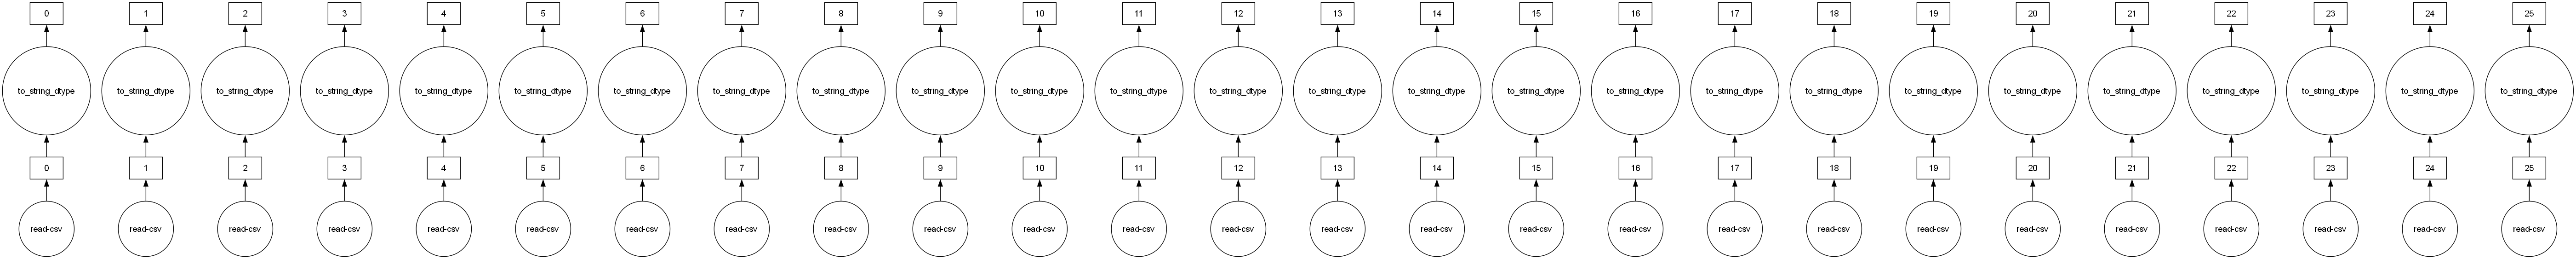

In [3]:
df_jan.visualize(tasks=True, filename=None)

Clearly, there are 26 chunks.

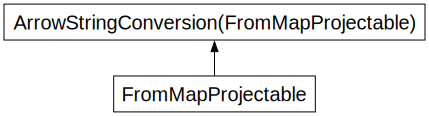

In [4]:
df_jan.visualize(tasks=False, filename=None)

## Shape of all the datasets

In [5]:
print(f"Shape of January dataset: {df_jan.shape}")
print(f"Shape of February dataset: {df_feb.shape}")
print(f"Shape of March dataset: {df_mar.shape}")

Shape of January dataset: (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(aebacdd)).size() // 19, dtype=int64>, 19)
Shape of February dataset: (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(45e2f7d)).size() // 19, dtype=int64>, 19)
Shape of March dataset: (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(8376d8f)).size() // 19, dtype=int64>, 19)


The number of rows are not visible, whereas the number of columns are. This is because when we read the data using `Dask` without running the `compute` method, it only stores the metadata, which includes the columns but not the rows.

## Concatenating the three datasets

Now, I will concatenate all the three datasets and drop irrelevant columns.

In [6]:
cols_to_drop = ["extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "payment_type"]

df = dd.concat([df_jan, df_feb, df_mar], axis=0).drop(columns=cols_to_drop)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount
npartitions=82,,,,,,,,,,,,
,float64,string,string,float64,float64,float64,float64,float64,string,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


We can see that concatenating all the three datasets increases the number of partitions from 26 to 82.

Let us now visualize this concatenation and dropping (`concat` and `drop` operations are chained one after the other).

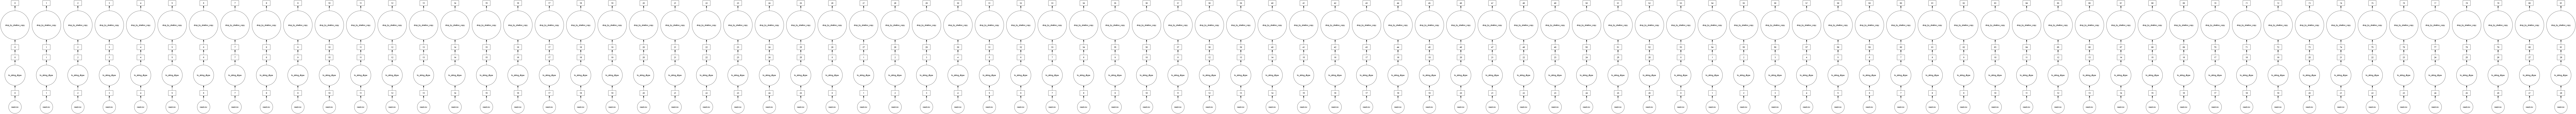

In [7]:
df.visualize(tasks=True, filename=None)

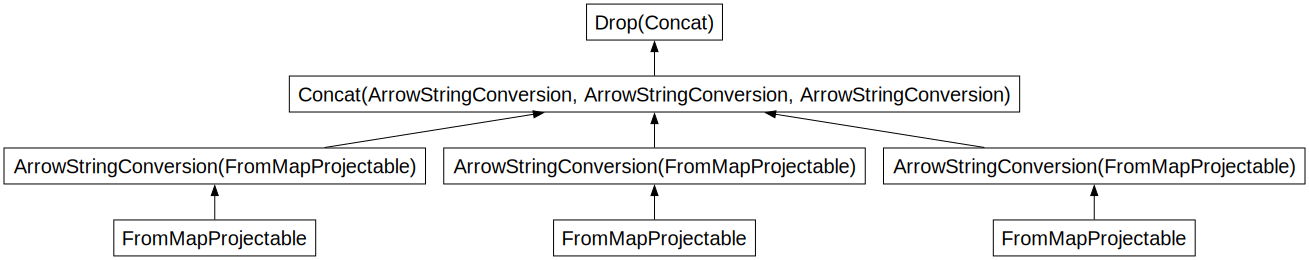

In [8]:
df.visualize(tasks=False, filename=None)

Let us now look at the top 10 rows.

In [9]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount
0,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,2.0,1.10,-73.990372,40.734695,1.0,N,-73.981842,40.732407,7.5
1,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,5.0,4.90,-73.980782,40.729912,1.0,N,-73.944473,40.716679,18.0
2,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.0,10.54,-73.984550,40.679565,1.0,N,-73.950272,40.788925,33.0
3,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,1.0,4.75,-73.993469,40.718990,1.0,N,-73.962242,40.657333,16.5
4,2.0,2016-01-01 00:00:00,2016-01-01 00:00:00,3.0,1.76,-73.960625,40.781330,1.0,N,-73.977264,40.758514,8.0
5,2.0,2016-01-01 00:00:00,2016-01-01 00:18:30,2.0,5.52,-73.980118,40.743050,1.0,N,-73.913490,40.763142,19.0
6,2.0,2016-01-01 00:00:00,2016-01-01 00:26:45,2.0,7.45,-73.994057,40.719990,1.0,N,-73.966362,40.789871,26.0
7,1.0,2016-01-01 00:00:01,2016-01-01 00:11:55,1.0,1.20,-73.979424,40.744614,1.0,N,-73.992035,40.753944,9.0
8,1.0,2016-01-01 00:00:02,2016-01-01 00:11:14,1.0,6.00,-73.947151,40.791046,1.0,N,-73.920769,40.865578,18.0
9,2.0,2016-01-01 00:00:02,2016-01-01 00:11:08,1.0,3.21,-73.998344,40.723896,1.0,N,-73.995850,40.688400,11.5


Inside the `head` method, `compute` is by default set to `True`. Hence we get this output.

## Missing values

Let us create a task flow to compute missing values.

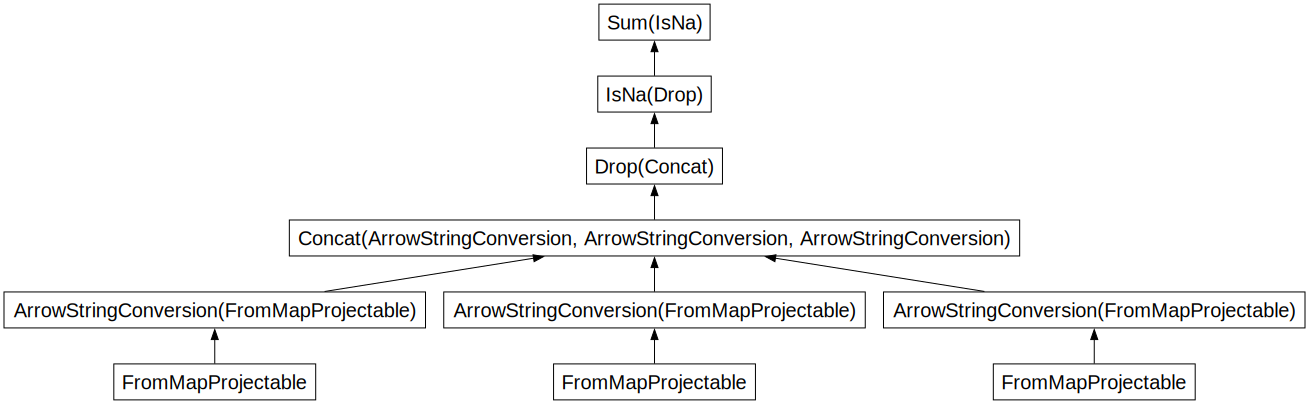

In [10]:
df.isna().sum().visualize(tasks=False, filename=None)

We can clearly see the flow, i.e.,

$$
\text{Reading three datasets} \rightarrow \text{concatenating} \rightarrow \text{dropping irrelevant columns} \rightarrow \text{checking na values} \rightarrow \text{summing na values}
$$

Let us now use the `compute` method to find the number of missing values.

In [11]:
df.isna().sum().compute()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
fare_amount              0
dtype: int64

Clearly, there are no missing values in the data.

## Statistical summary of numerical columns

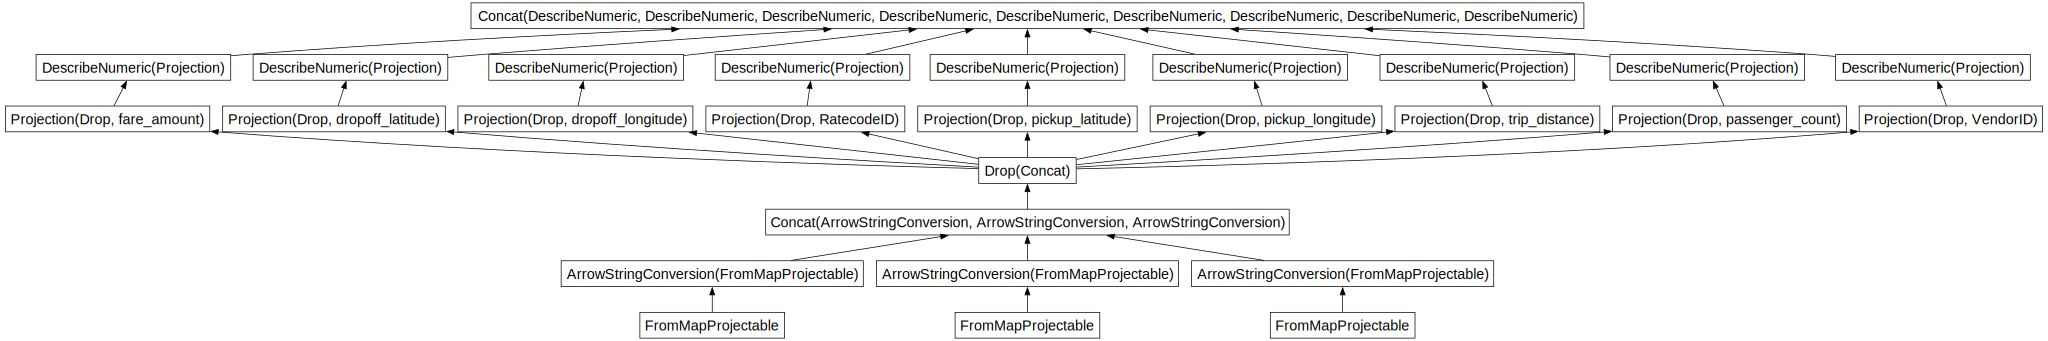

In [12]:
df.describe().visualize(tasks=False, filename=None)

In [13]:
df.describe().compute()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,fare_amount
count,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07
mean,1.532576e+00,1.661700e+00,5.309408e+00,-7.283942e+01,4.012605e+01,1.039150e+00,-7.290482e+01,4.016297e+01,1.257198e+01
std,4.989377e-01,1.316154e+00,4.672575e+03,9.090656e+00,5.007832e+00,5.564537e-01,8.828348e+00,4.863875e+00,9.179006e+01
min,1.000000e+00,0.000000e+00,-3.390584e+06,-1.616987e+02,-7.703949e+01,1.000000e+00,-1.616987e+02,-7.703949e+01,-9.576000e+02
25%,1.000000e+00,1.000000e+00,1.100000e+00,-7.399055e+01,4.074137e+01,1.000000e+00,-7.399009e+01,4.074001e+01,7.000000e+00
50%,2.000000e+00,1.000000e+00,1.930000e+00,-7.397922e+01,4.075640e+01,1.000000e+00,-7.397832e+01,4.075612e+01,1.000000e+01
75%,2.000000e+00,2.000000e+00,3.800000e+00,-7.396252e+01,4.076979e+01,1.000000e+00,-7.395599e+01,4.077166e+01,1.550000e+01
max,2.000000e+00,9.000000e+00,1.907263e+07,9.464387e+01,6.685682e+01,9.900000e+01,3.889659e+01,4.053167e+02,4.294967e+05


Some values do not make sense, for example, the max value of `trip_distance` is $\approx 1.9\times 10^{7}$, i.e., 19 million miles. This clearly seems like an erroneous value. Also, NYC lies to the west of the prime meridian, and hence longitudes cannot be positive. But, the max value of `pickup_longitude` is positive, which again seems like an erroneous value. Similarly, the latitude values for NYC should be positive as it lies above the equator. Hence, there are errors in the latitude columns as well. The max value of the `fare_amount` column is $\approx \$ 4.29\times 10^{5}$, i.e., $429,000. This also seems erroneous as it is too high.

Let us now do column-wise analysis.

## `VendorID`

This column only contains 2 vendors, as shown in the attributes table. Let us use `value_counts` on it.

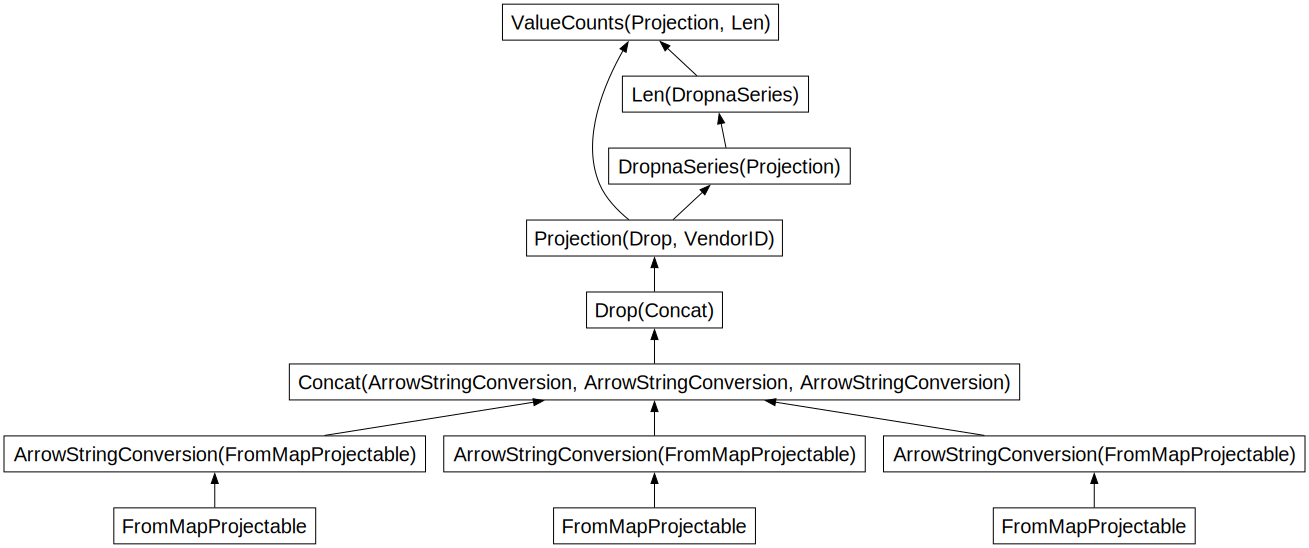

In [14]:
df["VendorID"].value_counts(normalize=True).visualize(tasks=False, filename=None)

Let us now plot a piechart for visualization.

In [15]:
vendor_share = df["VendorID"].value_counts(normalize=True).compute()
vendor_share

VendorID
2.0    0.532576
1.0    0.467424
Name: proportion, dtype: float64

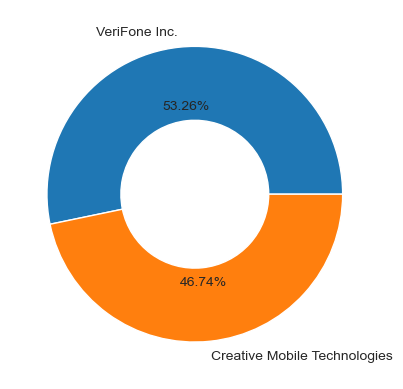

In [16]:
plt.pie(
    vendor_share,
    labels=["VeriFone Inc.", "Creative Mobile Technologies"],
    autopct="%.2f%%",
    radius=1,
    wedgeprops=dict(width=0.5, edgecolor="w")
)
plt.show();

This column is more or less balanced.

## `passenger_count`

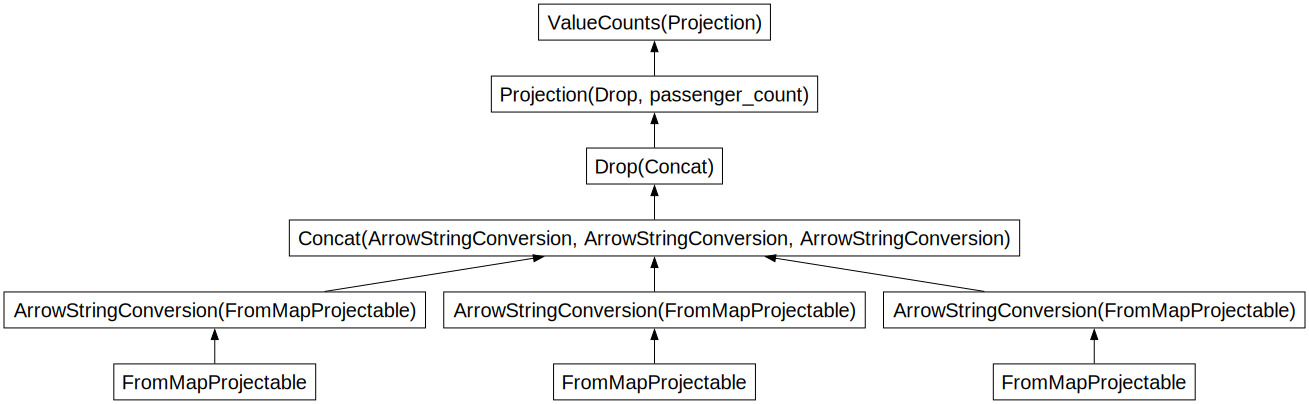

In [17]:
df["passenger_count"].value_counts().visualize(tasks=False, filename=None)

In [18]:
passenger_count_value_counts = df["passenger_count"].value_counts().compute()

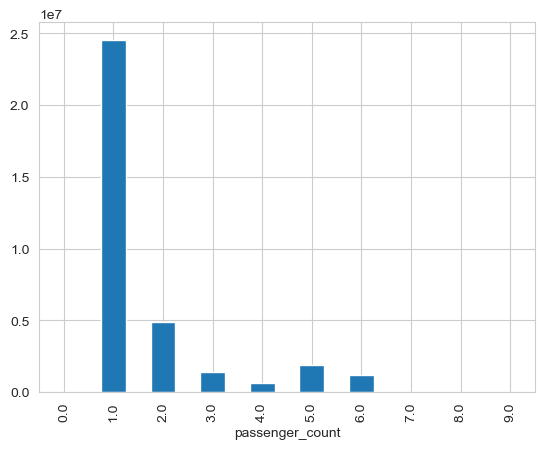

In [19]:
passenger_count_value_counts.sort_index().plot(kind="bar")
plt.show();

The `passenger_count`s outside the range of 1 to 5 are erroneous as they are not allowed by the NYC Taxi & Limousine Commission.

## `trip_distance`

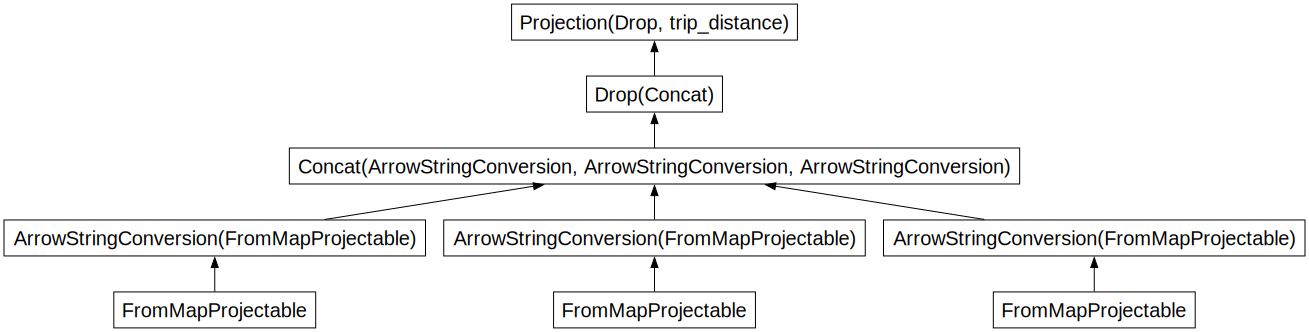

In [20]:
df["trip_distance"].visualize(tasks=False, filename=None)

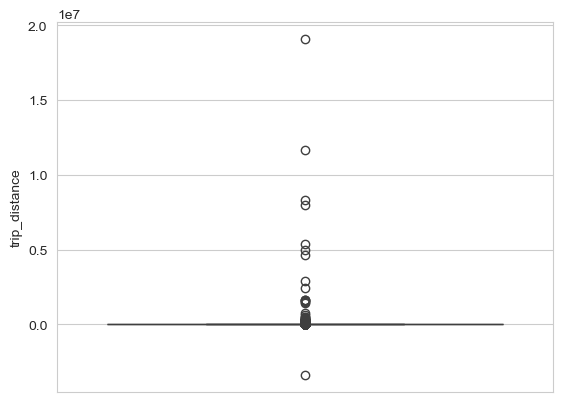

In [21]:
sns.boxplot(df["trip_distance"].compute());

There are a lot of some rather outrageous outliers in `trip_distance`. Let us calculate from the 10th to 90th percentile values of `trip_distance` to better understand the distribution of `trip_distance`.

In [22]:
percentile_values = np.arange(0.1, 1.1, 0.1)
percentile_values

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [23]:
for value in percentile_values:
    print(f"The {int(value * 100)}th percentile value of `trip_distance` is {df['trip_distance'].quantile(q=value).compute()}.")

The 10th percentile value of `trip_distance` is 0.7.
The 20th percentile value of `trip_distance` is 0.97.
The 30th percentile value of `trip_distance` is 1.23.
The 40th percentile value of `trip_distance` is 1.56.
The 50th percentile value of `trip_distance` is 1.93.
The 60th percentile value of `trip_distance` is 2.49.
The 70th percentile value of `trip_distance` is 3.27.
The 80th percentile value of `trip_distance` is 4.6.
The 90th percentile value of `trip_distance` is 8.3.
The 100th percentile value of `trip_distance` is 19072628.8.


As we can see, there are no outliers in this range, i.e., from the 10th to 90th percentile. Let us now check the same from 90th to 100th percentile.

In [24]:
percentile_values = np.arange(0.90, 1.01, 0.01)
for value in percentile_values:
    print(f"The {int(value * 100)}th percentile value of `trip_distance` is {df['trip_distance'].quantile(q=value).compute()}.")

The 90th percentile value of `trip_distance` is 8.3.
The 91th percentile value of `trip_distance` is 8.91.
The 92th percentile value of `trip_distance` is 9.53.
The 93th percentile value of `trip_distance` is 10.2.
The 94th percentile value of `trip_distance` is 10.95.
The 95th percentile value of `trip_distance` is 12.1.
The 96th percentile value of `trip_distance` is 14.680000000000582.
The 97th percentile value of `trip_distance` is 16.91.
The 98th percentile value of `trip_distance` is 17.95.
The 99th percentile value of `trip_distance` is 19.375500000000464.
The 100th percentile value of `trip_distance` is 19072628.8.


In [25]:
percentile_values = np.arange(0.99, 1.001, 0.001)
for value in percentile_values:
    print(f"The {round(value * 100, 1)}th percentile value of `trip_distance` is {df['trip_distance'].quantile(q=value).compute()}.")

The 99.0th percentile value of `trip_distance` is 19.375499999999885.
The 99.1th percentile value of `trip_distance` is 19.6.
The 99.2th percentile value of `trip_distance` is 19.89.
The 99.3th percentile value of `trip_distance` is 20.08.
The 99.4th percentile value of `trip_distance` is 20.4.
The 99.5th percentile value of `trip_distance` is 20.8.
The 99.6th percentile value of `trip_distance` is 21.2.
The 99.7th percentile value of `trip_distance` is 21.74.
The 99.8th percentile value of `trip_distance` is 22.69.
The 99.9th percentile value of `trip_distance` is 26.97440000000177.
The 100.0th percentile value of `trip_distance` is 19072628.8.


It looks like a very tiny fraction of values in `trip_distance` are unresonably high. We can take all the positive values in this column till the 99.9th percentile, and then drop the remaining ones for training. However, the `trip_distance` is calculated using the latitude and longitude columns. So we may want to investigate them too as the corresponding values for them may also be outliers.

## `fare_amount`

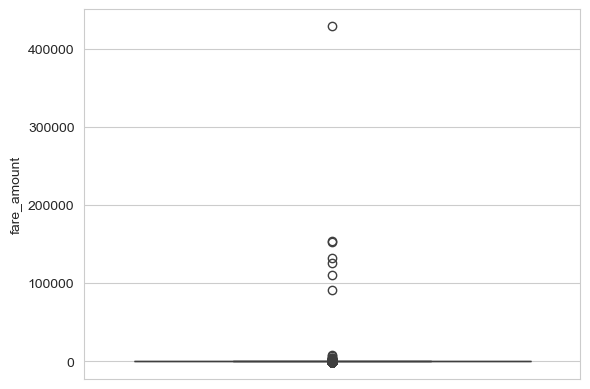

In [26]:
sns.boxplot(df["fare_amount"].compute());

Again we have outliers. Let us check the same percentile values for `fare_amount`.

In [27]:
percentile_values = np.arange(0.1, 1.1, 0.1)
for value in percentile_values:
    print(f"The {int(value * 100)}th percentile value of `fare_amount` is {df['fare_amount'].quantile(q=value).compute()}.")

The 10th percentile value of `fare_amount` is 5.0.
The 20th percentile value of `fare_amount` is 6.0.
The 30th percentile value of `fare_amount` is 7.5.
The 40th percentile value of `fare_amount` is 8.5.
The 50th percentile value of `fare_amount` is 10.0.
The 60th percentile value of `fare_amount` is 11.5.
The 70th percentile value of `fare_amount` is 14.0.
The 80th percentile value of `fare_amount` is 18.0.
The 90th percentile value of `fare_amount` is 27.0.
The 100th percentile value of `fare_amount` is 429496.72.


In [28]:
percentile_values = np.arange(0.90, 1.01, 0.01)
for value in percentile_values:
    print(f"The {int(value * 100)}th percentile value of `fare_amount` is {df['fare_amount'].quantile(q=value).compute()}.")

The 90th percentile value of `fare_amount` is 27.0.
The 91th percentile value of `fare_amount` is 29.0.
The 92th percentile value of `fare_amount` is 30.5.
The 93th percentile value of `fare_amount` is 33.0.
The 94th percentile value of `fare_amount` is 35.5.
The 95th percentile value of `fare_amount` is 40.0.
The 96th percentile value of `fare_amount` is 49.5.
The 97th percentile value of `fare_amount` is 52.0.
The 98th percentile value of `fare_amount` is 52.0.
The 99th percentile value of `fare_amount` is 52.0.
The 100th percentile value of `fare_amount` is 429496.72.


In [29]:
percentile_values = np.arange(0.99, 1.001, 0.001)
for value in percentile_values:
    print(f"The {round(value * 100, 1)}th percentile value of `fare_amount` is {df['fare_amount'].quantile(q=value).compute()}.")

The 99.0th percentile value of `fare_amount` is 52.0.
The 99.1th percentile value of `fare_amount` is 52.0.
The 99.2th percentile value of `fare_amount` is 53.5.
The 99.3th percentile value of `fare_amount` is 55.5.
The 99.4th percentile value of `fare_amount` is 56.5.
The 99.5th percentile value of `fare_amount` is 60.0.
The 99.6th percentile value of `fare_amount` is 64.0.
The 99.7th percentile value of `fare_amount` is 68.0.
The 99.8th percentile value of `fare_amount` is 73.0.
The 99.9th percentile value of `fare_amount` is 97.0.
The 100.0th percentile value of `fare_amount` is 429496.72.


Again, only a tiny fraction of `fare_amount` seems to be unresonably high. Again, `fare_amount` also depends on the latitude and longitude coordinates, just like `trip_distance`. So, if we get rid of the erroneous latitude and longitude coordinates, it may remove these outliers as well.

## `RatecodeID`

In [30]:
rate_code_id_value_counts = df["RatecodeID"].value_counts().compute()

In [31]:
rate_code_id_value_counts.sort_index()

RatecodeID
1.0     33627000
2.0       697595
3.0        56169
4.0        14459
5.0       103481
6.0          320
99.0         835
Name: count, dtype: int64

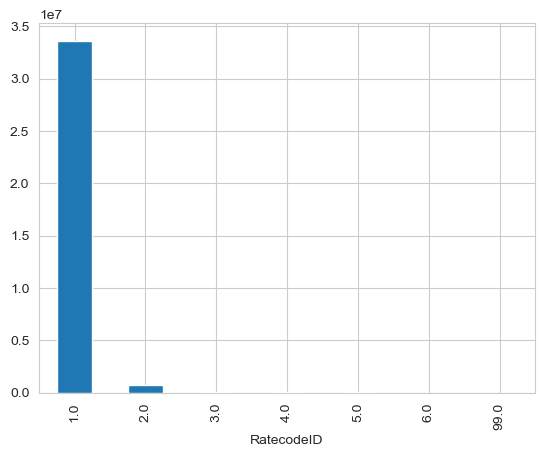

In [32]:
rate_code_id_value_counts.sort_index().plot(kind="bar")
plt.show();

Seems like the missing values in `RatecodeID` is replaced with `99.0`.

## Location-based columns

In [33]:
location_subset = df[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]]
location_subset

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
npartitions=82,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


Let us plot boxplots for each of these 4 columns to understand their distribution.

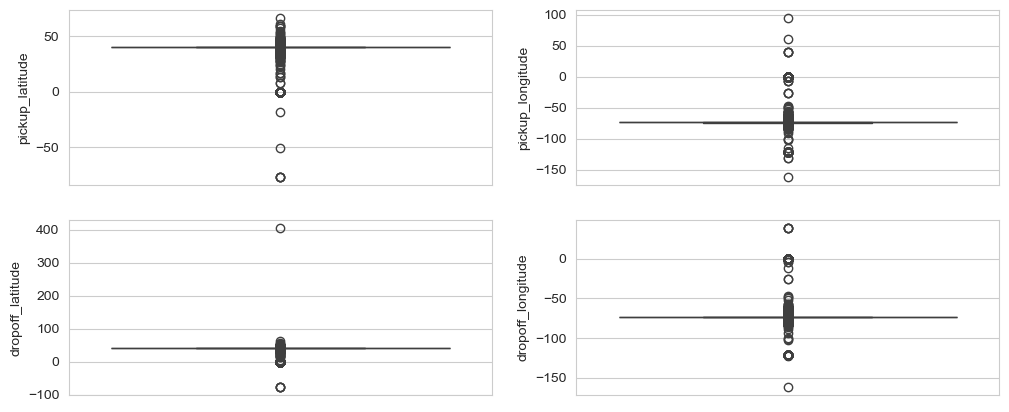

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
for i in range(4):
    if i <= 1:  # pickup
        sns.boxplot(y=location_subset.iloc[:, i].compute(), ax=ax1[i])
    else:  # dropoff
        sns.boxplot(y=location_subset.iloc[:, i].compute(), ax=ax2[i - 2])

There are outliers in all these location-based columns. Since we need these columns to divide NYC into regions, we will drop these outliers.

## `store_and_fwd_flag`

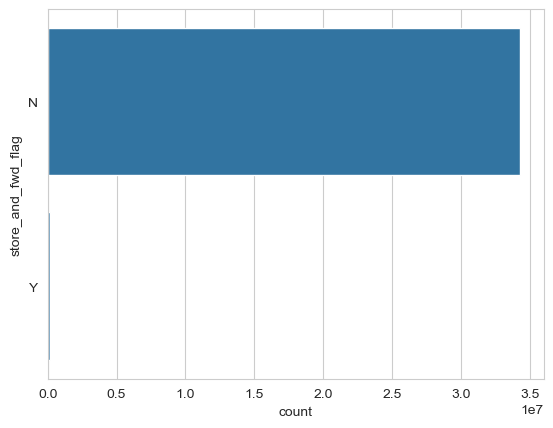

In [35]:
sns.countplot(df["store_and_fwd_flag"].compute());

We can see that the vast majority of the values are `N`, which means that for the vast majority of the trips the trip record was not held in memory. The ones that are `Y` may have had temporary server or connectivity issues.

## Date-time columns

Let us first make sure that these columns are in the proper `datetime` format.

In [36]:
datetime_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]

for col in datetime_cols:
    df[col] = dd.to_datetime(df[col], yearfirst=True, format="mixed")

Let us create new columns using `tpep_pickup_datetime`.

In [37]:
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_day_of_week"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour

df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,pickup_month,pickup_day_of_week,pickup_hour
npartitions=82,,,,,,,,,,,,,,,
,float64,datetime64[ns],datetime64[ns],float64,float64,float64,float64,float64,string,float64,float64,float64,int32,int32,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [38]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'pickup_month',
       'pickup_day_of_week', 'pickup_hour'],
      dtype='object')

In [39]:
df.dtypes

VendorID                         float64
tpep_pickup_datetime      datetime64[ns]
tpep_dropoff_datetime     datetime64[ns]
passenger_count                  float64
trip_distance                    float64
pickup_longitude                 float64
pickup_latitude                  float64
RatecodeID                       float64
store_and_fwd_flag       string[pyarrow]
dropoff_longitude                float64
dropoff_latitude                 float64
fare_amount                      float64
pickup_month                       int32
pickup_day_of_week                 int32
pickup_hour                        int32
dtype: object

Let us now visualize our operations.

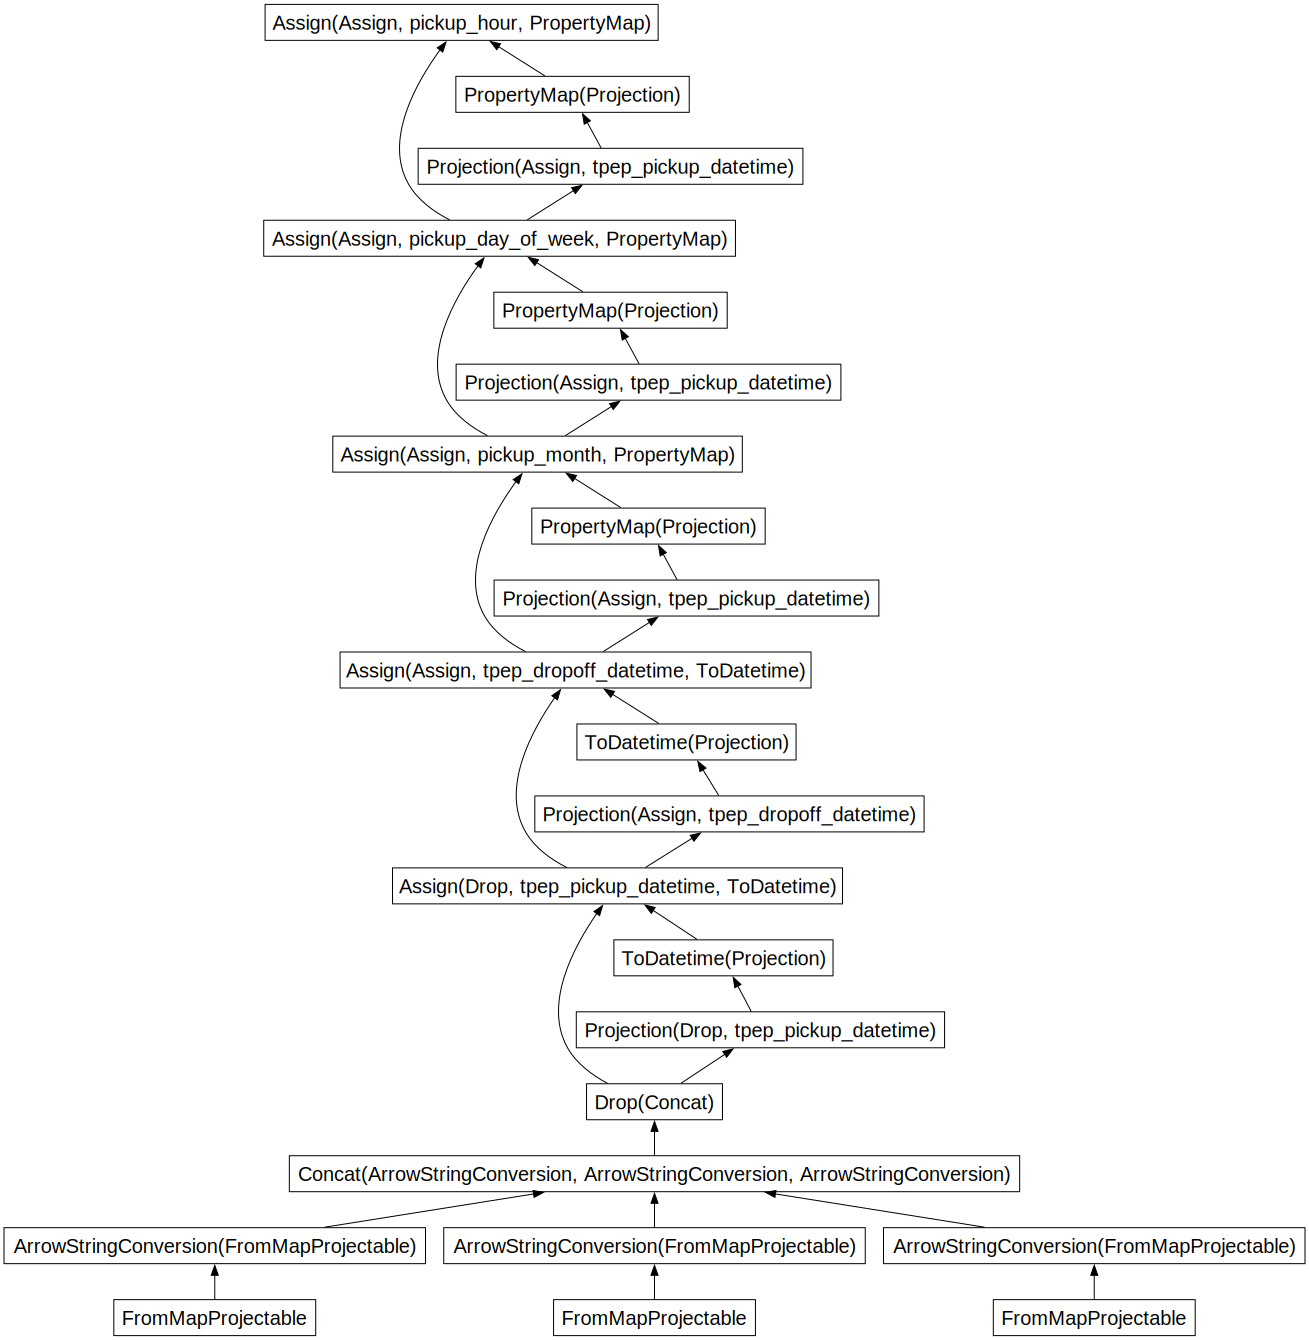

In [40]:
df.visualize(tasks=False, filename=None)

Let us now find the number of pickups in every 3 days.

In [41]:
pickups_every_3_days = (
    df
    .set_index("tpep_pickup_datetime")  # sets the `tpep_pickup_datetime` column as index
    .resample("3D")  # resamples the data in 3-day frequency of `tpep_pickup_datetime`
    .size()  # calculates the number of pickups after resampling
    .compute()
)

In [42]:
pickups_every_3_days

tpep_pickup_datetime
2016-01-01     960746
2016-01-04    1007938
2016-01-07    1162789
2016-01-10    1061829
2016-01-13    1192852
2016-01-16    1132536
2016-01-19    1166946
2016-01-22     658061
2016-01-25     968922
2016-01-28    1232734
2016-01-31    1065990
2016-02-03    1176173
2016-02-06    1144752
2016-02-09    1192598
2016-02-12    1285409
2016-02-15    1101217
2016-02-18    1256220
2016-02-21    1114674
2016-02-24    1251497
2016-02-27    1155024
2016-03-01    1208179
2016-03-04    1270530
2016-03-07    1106194
2016-03-10    1273983
2016-03-13    1134075
2016-03-16    1234570
2016-03-19    1176151
2016-03-22    1155525
2016-03-25    1149227
2016-03-28    1108463
2016-03-31     394055
Freq: 3D, dtype: int64

Let us plot this series.

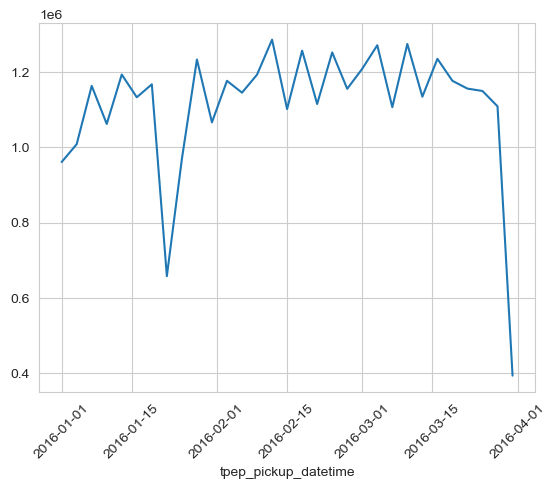

In [43]:
sns.lineplot(pickups_every_3_days)
plt.xticks(rotation=45)
plt.show();

We may want to investigate these drops.

Let us now investigate pickups each hour grouped by the `pickup_hour` and `pickup_day_of_week`.

In [44]:
pickups_each_hour = (
    df
    .groupby(["pickup_hour", "pickup_day_of_week"])["VendorID"]
    .count()
    .compute()
)

In [45]:
pickups_each_hour

pickup_hour  pickup_day_of_week
4            3                      32480
6            3                     138392
12           6                     252128
18           2                     325121
9            3                     266450
                                    ...  
12           2                     241018
13           2                     237579
17           1                     258707
19           1                     312484
23           5                     299024
Name: VendorID, Length: 168, dtype: int64

In [46]:
pickups_each_hour = pickups_each_hour.reset_index()
pickups_each_hour

,pickup_hour,pickup_day_of_week,VendorID
0,4,3,32480
1,6,3,138392
2,12,6,252128
3,18,2,325121
4,9,3,266450
...,...,...,...
163,12,2,241018
164,13,2,237579
165,17,1,258707
166,19,1,312484


In [47]:
pickups_each_hour.rename(columns={"VendorID": "number_of_pickups"}, inplace=True)
pickups_each_hour

,pickup_hour,pickup_day_of_week,number_of_pickups
0,4,3,32480
1,6,3,138392
2,12,6,252128
3,18,2,325121
4,9,3,266450
...,...,...,...
163,12,2,241018
164,13,2,237579
165,17,1,258707
166,19,1,312484


Let us now create a dictionary that maps the `pickup_day_of_week` to the names of the days.

In [48]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
day_of_week_mapper = {k:v for k, v in enumerate(day_names)}
day_of_week_mapper

{0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [49]:
pickups_each_hour.replace({"pickup_day_of_week": day_of_week_mapper}, inplace=True)
pickups_each_hour

,pickup_hour,pickup_day_of_week,number_of_pickups
0,4,Thu,32480
1,6,Thu,138392
2,12,Sun,252128
3,18,Wed,325121
4,9,Thu,266450
...,...,...,...
163,12,Wed,241018
164,13,Wed,237579
165,17,Tue,258707
166,19,Tue,312484


Let us now see how the `number_of_pickups` change with each `pickup_hour`, and how this varies with `pickup_day_of_week`.

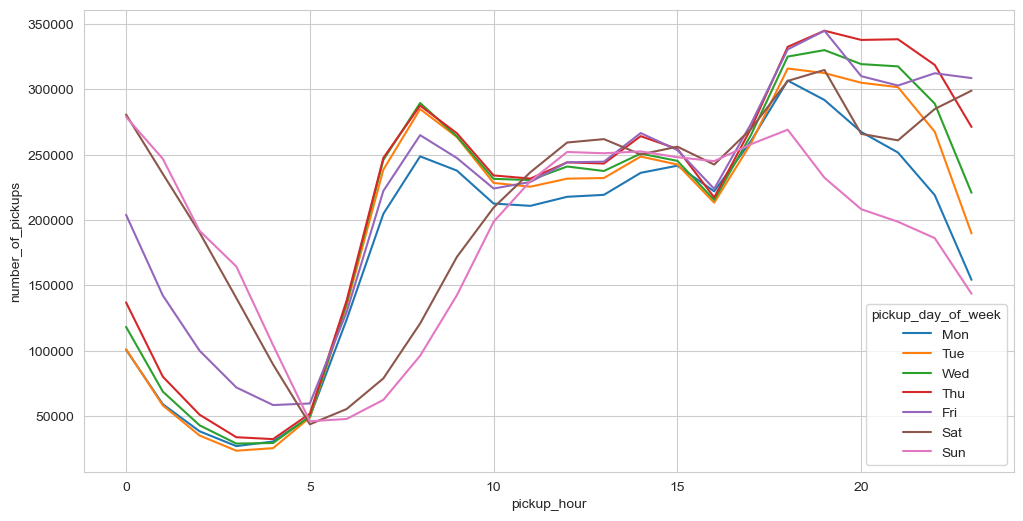

In [50]:
fig = plt.figure(figsize=(12, 6))
sns.lineplot(
    pickups_each_hour,
    x="pickup_hour",
    y="number_of_pickups",
    hue="pickup_day_of_week",
    hue_order=day_names
)
plt.show();

* The `number_of_pickups` on all the days are the least from midnight till 5 a.m.
* The `number_of_pickups` are significantly different on weekdays as compared to weekends.
    - On weekdays, the `number_of_pickups` sharply increase from 5 a.m., i.e., during office hours.
    - On weekends, the `number_of_pickups` increase gradually from 5 a.m. as the offices are closed.
* The `number_of_pickups` are more in the evenings as during the weekdays people go home at this time from offices, and during weekends people party.
* So, the `pickup_hour` and `pickup_day_of_week` are important features that affect the `number_of_pickups` in NYC.